# Problem Set 3 - Matias Castro Tapia 

In [1]:
import numpy as np
from astropy.io import fits
from matplotlib import pyplot as plt

I read the file with the data and made a plot of the total map

In [2]:
hdul=fits.open('advact_tt_patch.fits')
map=hdul[0].data
hdul.close()
map=np.asarray(map,dtype='float')

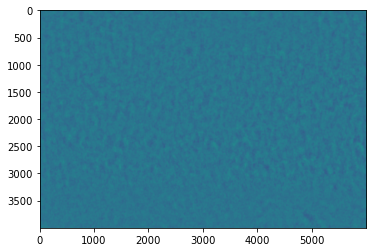

In [3]:
plt.imshow(map)
plt.show()

Now, I took a portion close to the center.

In [4]:
x0=3000
y0=2000
width=20
#patch=mnorm[y0-width:y0+width,x0-width:x0+width]
patch=map[y0-width:y0+width,x0-width:x0+width]

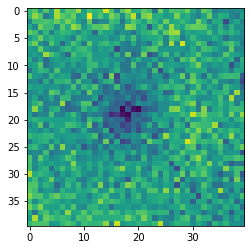

In [5]:
plt.imshow(patch)
plt.show()

The target seems to be similar to a Gaussian inverted, then I defined the routine mygauss to fit a Gaussian on two dimensions as follows: 
$$Ae^{-((x-dx)^{2}+(y-dy)^{2})/2\sigma^{2}}+B$$
So we want to find the best parameters $A$, $dx$, $dy$, $\sigma$, and $B$.

In [6]:
def mygauss(pars,width):
    vec=np.asarray(np.arange(-width,width),dtype='float')
    amp=pars[0]
    dx=pars[1]
    dy=pars[2]
    sig=pars[3]
    b=pars[4]
    
    xvec=vec-dx
    yvec=vec-dy
    xmat=np.outer(xvec,np.ones(len(xvec)))
    ymat=np.outer(np.ones(len(yvec)),yvec)
    rmat=xmat**2+ymat**2
    model=np.exp(-0.5*(rmat/sig**2))*amp

    #return model
    return b+model

I defined a first guess of the parameters.

In [7]:
pars_s=np.array([-400,-1,-3,1.5,9])

In [8]:
gauss_s=mygauss(pars_s,20) 

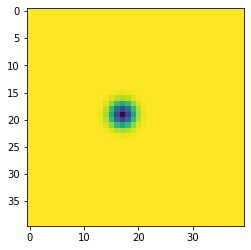

In [9]:
plt.imshow(gauss_s)#,vmin=-400,vmax=400)
plt.show()

Then, I used the Newton's method to find a root of $\nabla\chi^{2}$ for the set of parameters $m$. Then, the iterative method can be applied using a Taylor expansion for $A(m)=A(m_{0})+A'(m_{0})\delta{m}$, and considering the residual $r=d-A(m_{0})$, the new definition for $\chi^{2}=(r-A'(m_{0}))^{T}N^{-1}(r-A'(m_{0}))$. And asuming that $\delta{m}$ is very small we want to solve $\nabla{\chi^{2}}=-A'^{T}(m_{0})N^{-1}(r-A'(m_{0})\delta{m})=0$. Thus, $\delta{m}=(A'^{T}(m_{0})N^{-1}A'(m_{0}))^{-1}A'^{T}(m_{0})N^{-1}r$, and the iteration for finding a root of $\nabla{\chi^{2}}$ is $m_{n+1}=m_{n}+\delta{m}$.

I used a routine called newton to take 10 times the routine get_model_derivs_ravel and iterates from the initial guess and taking a step of $\delta{m}$ as estimated above. This 10 steps is more than enough to note that the routine have converged and the square sum of the residuals does not change a lot. The routine get_model_derivs_ravel takes the numerical derivates made using the 2D Gaussian defined before and get_model_derivs and reorders it to have a matrix like it was defined in 1D, in this way, the newton method could be applied as always.

In [10]:
def get_model_derivs(fun,pars,dpar,width):
    model=fun(pars,width)
    npar=len(pars)
    derivs=[None]*npar
    for i in range(npar):
        pp=pars.copy()
        pp[i]=pars[i]+dpar[i]
        m_plus=fun(pp,width)
        pp[i]=pars[i]-dpar[i]
        m_minus=fun(pp,width)
        derivs[i]=(m_plus-m_minus)/(2*dpar[i])
    return model,derivs

def get_model_derivs_ravel(fun,pars,dpar,width):
    model,derivs=get_model_derivs(fun,pars,dpar,width)
    model=np.ravel(model)
    npar=len(pars)
    derivs_out=np.empty([len(model),len(pars)])
    for i in range(npar):
        derivs_out[:,i]=np.ravel(derivs[i])
    return model,derivs_out

def newton(pars,data,fun,width,dpar,niter=10):
    for i in range(niter):
        model,derivs=get_model_derivs_ravel(fun,pars,dpar,width)
        resid=data-model
        lhs=derivs.T@derivs
        rhs=derivs.T@resid
        shift=np.linalg.pinv(lhs)@rhs
        print('parameter shifts are ',shift)
        pars=pars+shift
    return pars

dpar is an array with different scales of $h$ to estimate the numerical partial derivative as:
$$\frac{\partial G}{\partial m_{i}}=\frac{G(x,y,m1,...m_{i}+h_{i},...,m_{n})-G(x,y,m1,...m_{i}-h_{i},...,m_{n})}{2h_{i}}$$
This beause all the parameters have different orders of magnitude.

In [11]:
dpar=np.asarray([1.0,0.01,0.01,0.01,1.0])/10000

In [12]:
newpar=newton(pars_s,np.ravel(patch),mygauss,20,dpar,15)

parameter shifts are  [ 2.24361775e+02 -7.47315993e-02  2.42198529e-01  8.06769195e-01
 -1.02230048e+02]
parameter shifts are  [-29.85052798  -0.07826607   0.47273566   1.49258444   3.68978509]
parameter shifts are  [-0.1674415  -0.11211074 -0.16988317  0.36581018  4.85746508]
parameter shifts are  [ 5.41366897 -0.04279046 -0.04472344  0.17225839  0.89976333]
parameter shifts are  [ 2.59277486 -0.0246054  -0.03261205  0.08164334  0.35800438]
parameter shifts are  [ 1.31136201 -0.01176719 -0.01507449  0.03895433  0.1645059 ]
parameter shifts are  [ 0.62606484 -0.00562562 -0.00742066  0.01816496  0.07535393]
parameter shifts are  [ 0.29486817 -0.00261251 -0.0034458   0.00845083  0.03477396]
parameter shifts are  [ 0.13722017 -0.00121272 -0.0016112   0.00391008  0.01603088]
parameter shifts are  [ 0.0636103  -0.00056018 -0.00074485  0.00180762  0.00739866]
parameter shifts are  [ 0.02940919 -0.00025879 -0.00034468  0.00083466  0.00341369]
parameter shifts are  [ 0.0135848  -0.00011945 -0.

Below the Gaussian obtained using the best parameters from Newton's method.

In [13]:
gauss1=mygauss(newpar,20)

In [14]:
newpar

array([-195.16312856,   -1.35475304,   -2.5612083 ,    4.49187116,
        -83.12076035])

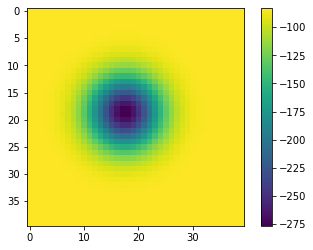

In [15]:
plt.imshow(gauss1)#,vmin=-400,vmax=400)
plt.colorbar()
plt.show()

Below is defined pad_map for obtain refletions of the input map. I also defined get_gauss_kernel, estimate_ps to obtain the smooth of the squared absolute value of the Fourier transform of the data; I smoothed doing a convolution with the gauss kernel defined.

In [16]:
def pad_map(map):
    map=np.hstack([map,np.fliplr(map)])
    map=np.vstack([map,np.flipud(map)])
    return map

In [17]:
pad_p=pad_map(patch)

In [18]:
def get_gauss_kernel(map,sig,norm=False):
    nx=map.shape[0]
    x=np.fft.fftfreq(map.shape[0])*map.shape[0]
    y=np.fft.fftfreq(map.shape[1])*map.shape[1]
    rsqr=np.outer(x**2,np.ones(map.shape[1]))+np.outer(np.ones(map.shape[0]),y**2)
    kernel=np.exp((-0.5/sig**2)*rsqr)
    if norm==True:
        kernel=kernel/kernel.sum()
    return kernel

In [19]:
def estimate_ps(m,sig):
    a2=(np.abs(np.fft.fft2(m))**2)
    g=(get_gauss_kernel(m,sig,True))
    f=np.fft.fft2(a2)*np.fft.fft2(g)
    return np.fft.ifft2(f)

Below the output of the estimate_ps for the selected patch. The plot is also shown in a logarithmic scale. The width of ok the gausss kernel is the $\sigma$ obtaines from Part 1

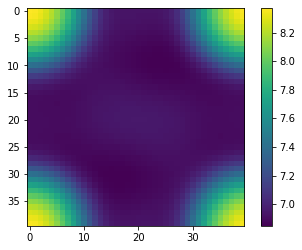

In [20]:
plt.imshow(np.real(np.log10(estimate_ps(patch,4.49))))
plt.colorbar()
plt.show()

I defined a larger patch to work with a larger portion of the map, below I also defined the filter_map routine to receive the power spectrum and the map to obtain $N^{-1}d$ using the Fourier space. I am normalizing $N$ for $n_{pix}$.

In [21]:
pt2=map[y0-500:y0+500,x0-500:x0+500]

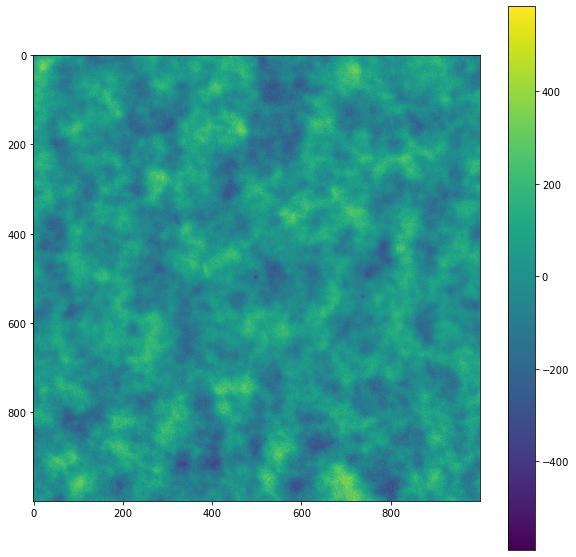

In [22]:
plt.figure(figsize=(10,10))
plt.imshow(pt2)
plt.colorbar()
plt.show()

In [23]:
ps=np.real(estimate_ps(pt2,4.49))

log of the power spectrum for the large patch

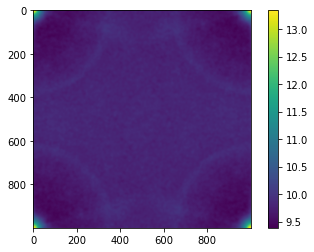

In [24]:
plt.imshow(np.log10(ps))
plt.colorbar()
plt.show()

In [25]:
def filter_map(m,noiseft):
    pft=(np.fft.fft2(m))
    patchft=pft/(noiseft/(len(m[0])*len(m)))
    patch_filt=np.real(np.fft.ifft2(patchft))
    return patch_filt

Applying the filter_map.

In [26]:
fil=filter_map(pt2,ps)

A plot of $N^{-1}d$ centered around the center.

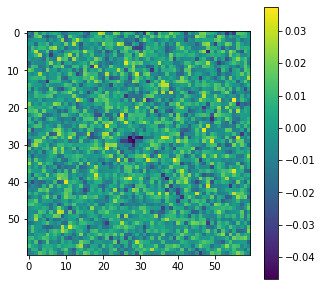

In [27]:
plt.figure(figsize=(5,5))
plt.imshow(fil[500-30:500+30,500-30:500+30])
plt.colorbar()

I defined the routine whitenoise to generate a white noise map of the dimensions of a given map and scaled for an amplitude amp. To generate the white noise I just assigned a random value between -1 and 1 to every pixel.

In [28]:
def whitenoise(map,amp):
    a=np.zeros([len(map),len(map[0])])
    for i in range(len(a)):
        for j in range(len(a[i])):
            a[i][j]=np.random.uniform(-1,1)
    return a*amp

In [29]:
wn=whitenoise(pt2,1)

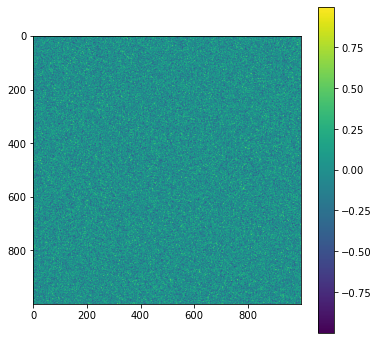

In [30]:
plt.figure(figsize=(6,6))
plt.imshow(wn)
plt.colorbar()
plt.show()

In [31]:
np.var(wn)

0.3332751686151395

We can note that the variance of the whitenoise profile is about 0.33. Below I applied the power spectrum and the filter_map to the white noise profile.

In [32]:
pswn=np.real(estimate_ps(wn,np.std(wn)))

In [33]:
filwn=filter_map(wn,pswn)

In [34]:
np.var(filwn)

2.7240574321338458

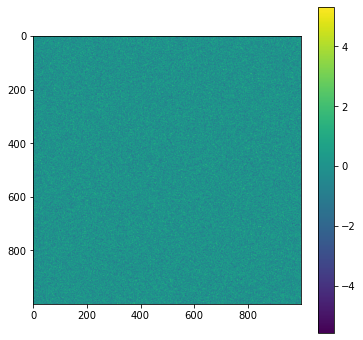

In [35]:
plt.figure(figsize=(6,6))
plt.imshow(filwn)
plt.colorbar()
plt.show()

In [36]:
(np.var(wn)*np.var(filwn))

0.9078607000117314

In [37]:
(np.var(fil)*np.var(pt2))

2.6890332381954147

In [38]:
np.var(filwn),np.var(wn)

(2.7240574321338458, 0.3332751686151395)

The variance of the filtered white noise was 2.72. However, the variance of the white noise must be of the order of the elements of $\sim N$, and the variance for the filtered white noise must be of the order of $\sim N^{-1}$. Then, the product between these variances should be $\sim 1$, as shown above it was $0.9$. This should roughly apply if we take the variance of the patch and the variance of the filtered map, the product between these was $2.7$ which is also of the order of $\sim 1$. Therefore, the normalization of the noise for a factor of $n_{pix}$ should be correct.

I defined the matched_filter to receive the patch where the filter must be applied, the power spectrum estimated, and the parameters from part 1 to use the width $\sigma$. First, the routine uses the filter_map output and obtains the Fourier transform of it. Second, the routine generates a Gaussian template with the width $\sigma$ obtained in Part 1 and computes the Fourier transform of it, thus it computes $A^{T}N^{-1}$ as $IFT(FT[N^{-1}]FT[A])$ where $FT[N^{-1}]$ is $power\_spectrum^{-1}$. The output of filter_map is $N^{-1}d$, then the output of the matched filter is $IFT(FT[A]FT^{*}[N^{-1}d])$. The routine returns both $IFT$ described and the template. 

In [39]:
def matched_filter(data,po_sp,pars):
    dat_filft=np.fft.fft2(filter_map(data,po_sp))
    
    x=np.fft.fftfreq(dat_filft.shape[0])*dat_filft.shape[0]
    y=np.fft.fftfreq(dat_filft.shape[1])*dat_filft.shape[1]
    rsqr=np.outer((x)**2,np.ones(len(y)))+np.outer(np.ones(len(x)),(y)**2)
    template=np.exp(-0.5*rsqr/(pars[3]**2))

    tft=np.fft.fft2(template)
   
    Ninvt=tft/(po_sp/(len(tft[0])*len(tft)))
    
    mf_rhs=np.real(np.fft.ifft2(tft*np.conj(dat_filft)))
    
    NinvA_real=np.real(np.fft.ifft2(Ninvt))
    
    return mf_rhs, NinvA_real,template

Applying the matched_filter and showing the plot of the matched filter.

In [40]:
mfout,N_1A,temp=matched_filter(pt2,ps,newpar)

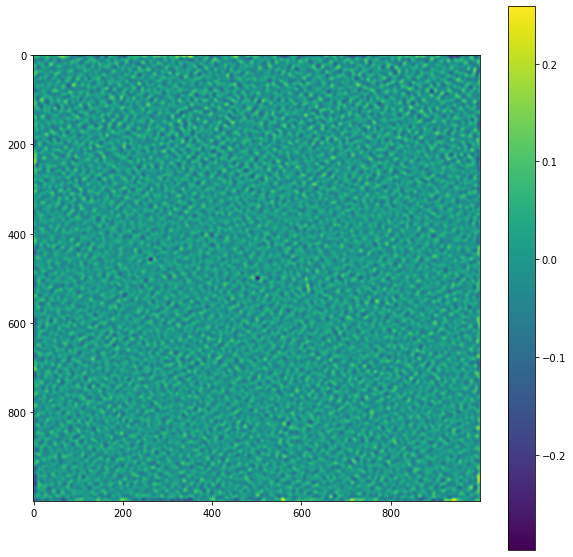

In [41]:
plt.figure(figsize=(10,10))
plt.imshow(mfout)
plt.colorbar()

We can see a cluster in the center, so we should take a portion near the center to estimate the amplitude as the value of the peak in the source from the output of the matched filter, divided by $A^{T}N^{-1}A$, which is obtained from the outputs called template and NinvA_real from the routine.

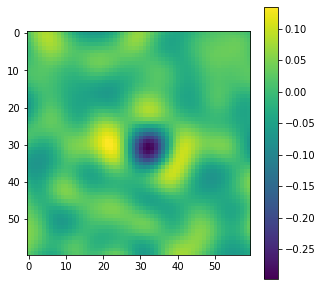

In [42]:
plt.figure(figsize=(5,5))
plt.imshow(mfout[500-30:500+30,500-30:500+30])
plt.colorbar()

In [43]:
np.min(mfout[500-30:500+30,500-30:500+30])

-0.29743078180625504

In [44]:
-0.29743078180625504/np.sum(temp*N_1A)

-212.38037916455863

The peak is $-0.29743078180625504$ and the absolute value of the amplitude is $212.38 \mu K$ (which is similar to what we expected from part 1 using the best-fit from the Newton's method $195.163\mu K$). The error bar in the amplitude is $1/\sqrt{A^{T}N^{-1}A}$ which is $26.72\mu K$

In [45]:
1/np.sqrt(np.sum(temp*N_1A))

26.721709576428253

If we compute the standard deviation of the portion of the map divided by $A^{T}N^{-1}A$ we can obtain an estimation for the error bar of the amplitude too.

In [46]:
np.std(mfout[500-30:500+30,500-30:500+30])/np.sum(temp*N_1A)

31.927775497950332

The value obtained is $31.93\mu K$ which is similar to what we obtained before.

Now we can look for another cluster in the matched_filter output. We can see that there is another cluster to the left and up, however, when comparing with the patch extracted directly from the map it seems that the matched filter inverted the coordinates. Then, the other cluster appears to the right of A2813 in the map, and to the left in the matched filter output.

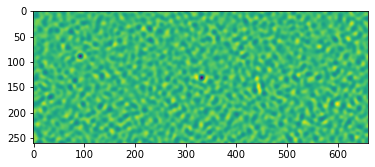

In [47]:
plt.figure(figsize=(6,6))
plt.imshow(mfout[500-30-100:500+30+100,500-30-300:500+30+300])
#plt.colorbar()
plt.show()

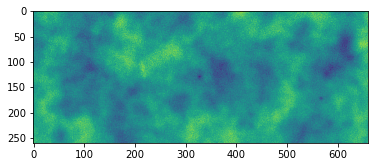

In [48]:
plt.figure(figsize=(6,6))
plt.imshow(pt2[500-30-100:500+30+100,500-30-300:500+30+300])
plt.show()

The horizontal difference in pixels is about 237 pixels, and 42 pixels in the vertical direction (I checked it making the plot multiple times near the other cluster). We should multiply for 30 arcsec and convert into degrees to search in the map. For A2813 we have RA 10.851667 deg, DEC -20.621389 deg (extracted from NED).

In [50]:
10.851667-237*(30/3600), -20.621389+42*(30/3600)

(8.876667000000001, -20.271389)

Then, the othe cluster should be near to RA 8.877 deg, DEC -20.271 deg. Searching in the NED database and the CDS portal, there is a cluster at RA 8.860721 deg, DEC -20.262794 deg called WHL J003526.2-201544 or MCS J0035.4-2015: https://ned.ipac.caltech.edu/byname?objname=WHL+J003526.2-201544&hconst=67.8&omegam=0.308&omegav=0.692&wmap=4&corr_z=1
http://cdsportal.u-strasbg.fr/?target=MCS%20J0035.4-2015